# Purpose

This notebook is to test whether the `neuro_op` module's nodes can successfully infer `world_dist` if only this distribution's information pieces $x_{world}$ are received (i.e., with rates h>0, r=0).

For this, the model is run with nodes receiving different amount of information (i.e., different `t_max`, `h`). Then, each node's posterior predictive distribution (*PPD*), equalling its forecast of future incoming information, is obtained via 
1. sampling of model parameters $\theta$ proportional to its posterior $p(\theta | x_{world})$;
2. using these sampled model parameters to generate data proportional to the model likelihood $p(x_{PPD}|\theta_{sampled})$

PPDs thereby fully conserves uncertainty by paying respect to both posterior and likelihood stochasticity.

We then use the PPDs to quantify the nodes' modelling accuracy by computing the Kullback-Leibler divergence and average MLE distances between node PPDs and data generated by `world_dist`.

In [1]:
import neuro_op as nop

import cProfile
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [2]:
# Reference input
input = dict(
    G=nop.build_random_network(N_nodes=100, N_neighbours=5),  # networkx graph object
    llf_nodes=st.norm,  # Likelihood function (llf) of nodes, Gaussian by default
    llf_world=st.norm,  # Likelihood function (llf) of world, Gaussian by default
    params_node=dict(  # Parameter priors of nodes (mu and associated uncertainty (standard deviation)), Gaussian by default
        loc=0,
        scale=10,
    ),
    sd_llf=1,  # Standard deviation of the likelihood function (llf) of nodes, assumed known & static
    params_world=dict(  # Likelihood function (llf) parameters of world, Gaussian by default
        loc=0,
        scale=1,
    ),
    h=1,  # Rate of external information draw events
    r=1,  # Rate of edge information exchange events
    t0=0,  # Start time of simulation
    t_max=50,  # End time of simulation
    t_sample=0.5,  # Periodicity for which samples and distance measures (KL-div, p-distance) are taken
    sample_bins=201,  # Number of bins used in distance measures
    sample_range=(
        -5,
        5,
    ),  # Interval over which distance measure distributions are considered
    p_distance_params=[
        (1, 1),
        (2, 1),
    ],  # List of tuples, each containing two floats, defining the p-distance parameters
    progress=False,  # Whether or not to print sampling times
)

In [3]:
# Exec times (s)
# ---
# llf_instance:     13.1
# llf improved:     7.4
# rng w. params:    6.78
# rng scaled        6.93

In [4]:
cProfile.run("nop.run_model_Param(**input)")

/home/jfriedel/Documents/Repos/neuro_op/src/neuro_op/neuro_op.py:298: RuntimeWarning: divide by zero encountered in log
  terms = P * np.log(P / Q)
/home/jfriedel/Documents/Repos/neuro_op/src/neuro_op/neuro_op.py:298: RuntimeWarning: invalid value encountered in multiply
  terms = P * np.log(P / Q)


         5498293 function calls (5498289 primitive calls) in 3.449 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <frozen codecs>:260(__init__)
        1    0.000    0.000    0.000    0.000 <frozen codecs>:309(__init__)
        6    0.000    0.000    0.000    0.000 <frozen codecs>:319(decode)
        1    0.002    0.002    3.449    3.449 <string>:1(<module>)
    10201    0.002    0.000    0.002    0.000 <string>:2(_parse_args)
     9948    0.008    0.000    0.147    0.000 <string>:5(_parse_args_rvs)
     9948    0.004    0.000    0.020    0.000 _continuous_distns.py:1831(_rvs)
    10201    0.070    0.000    0.070    0.000 _continuous_distns.py:304(_norm_logpdf)
    10201    0.004    0.000    0.074    0.000 _continuous_distns.py:365(_logpdf)
     9948    0.152    0.000    0.465    0.000 _distn_infrastructure.py:1017(rvs)
    10201    0.353    0.000    1.263    0.000 _distn_infra

In [5]:
out1 = nop.run_model_Param(**input)

print(out1["N_events"])

9807


## Data analysis

Random data analysis test notebook of steps later used in thorough analysis.


In [6]:
# For improving of readability, increase all font sizes of plots. Also, set legend location to upper right.
plt.rcParams.update(
    {
        "font.size": 20,
        "legend.loc": "upper right",
    }
)

#### Data analysis 1

Firstly, extract output values for further analysis:

In [7]:
for i in out1.keys():
    print(i)

nodes
G
world
N_events
t_end
mu_nodes
kl_divs
p_distances
seed



Each node's posteriors are plotted. One should see nodes' posteriors of model parameters (in this case, $\mu$), to converge around the true value. If not, nodes may need more information to converge ($\rightarrow$ increase $t_{max}, h$).


(array([ 1.,  1.,  4.,  1.,  4.,  8., 12.,  8.,  9.,  5., 13.,  9.,  3.,
         8.,  3.,  1.,  4.,  2.,  2.,  2.]),
 array([0.05368204, 0.05701679, 0.06035155, 0.0636863 , 0.06702106,
        0.07035581, 0.07369057, 0.07702532, 0.08036008, 0.08369483,
        0.08702958, 0.09036434, 0.09369909, 0.09703385, 0.1003686 ,
        0.10370336, 0.10703811, 0.11037287, 0.11370762, 0.11704238,
        0.12037713]),
 <BarContainer object of 20 artists>)

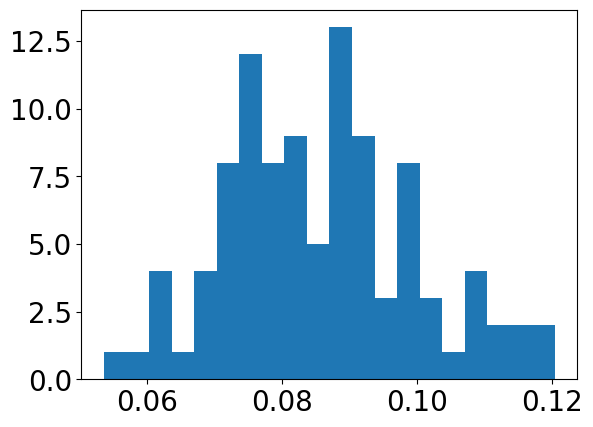

In [8]:
sigmas = []
for i in out1["nodes"]:
    sigmas += [i.params_node["scale"]]
plt.hist(sigmas, bins=20)

(-5.0, 5.0)

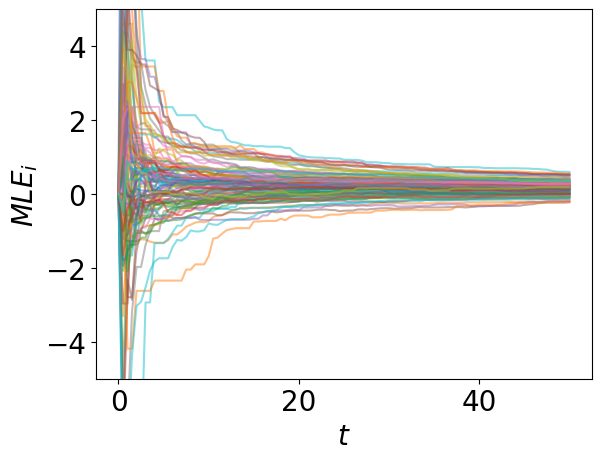

In [9]:
mu_arr = np.array(out1["mu_nodes"])
x = np.arange(input["t0"], input["t_max"] + input["t_sample"], input["t_sample"])
for i in range(len(mu_arr.T)):
    plt.plot(x, mu_arr.T[i], alpha=0.5, label=f"Node {i}")
    plt.xlabel("$t$")
    plt.ylabel("$MLE_i$")
plt.ylim(-5, 5)

#### Data analysis 2

In [10]:
N_iter = range(input["G"].number_of_nodes())
kld = np.array(out1["kl_divs"])
lin_dis = np.array(out1["p_distances"])[:, 0]
quad_dis = np.array(out1["p_distances"])[:, 1]
print(lin_dis.shape)
kld.shape
np.array(out1["p_distances"]).shape

(101, 100)


(101, 2, 100)

(101,)

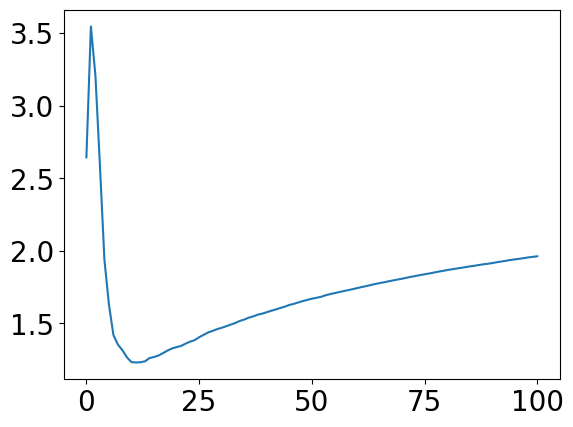

In [11]:
# for i in N_iter:
#    plt.plot(input["t_sample"] * np.arange(0, kld.shape[0]), kld[:, i, ])


i = 1
plt.plot(
    # input["t_sample"] * np.arange(0, kld.shape[0]),
    kld.mean(axis=i),
    label="avg",
)
kld.mean(axis=i).shape

In [12]:
for i in N_iter:
    plt.plot(input["t_sample"] * np.arange(0, quad_dis.shape[0]), quad_dis[:, 0, i])

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

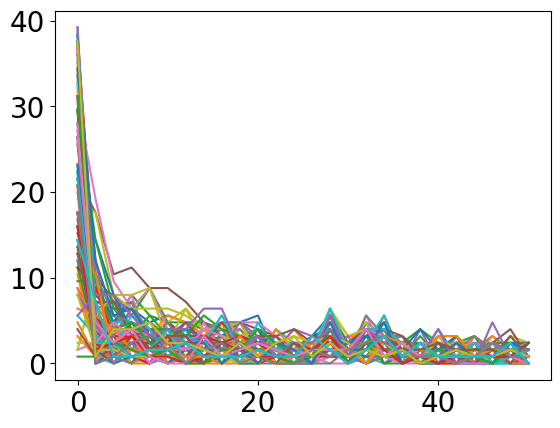

In [ ]:
for i in N_iter:
    plt.plot(input["t_sample"] * np.arange(0, lin_dis.shape[0]), lin_dis[:, 0, i])

In [ ]:
arr = np.array(out1["p_distances"])
print(arr.shape)
(arr[-1, 0, 1, :] ** 2).mean()

(26, 2, 2, 100)


2.8095999999999997

In [ ]:
arr2 = np.array(out1["kl_divs"])
arr2.shape
np.array(out1["mu_nodes"]).shape

(26, 100)

In [ ]:
arr[:, 0].shape

(26, 2, 100)